In [1]:
# Setup code
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numerics.matte4.ode import ode_adaptive, ode_solver, implicit_euler
from collections import deque
import numerics.numerical_integration as num_integ
import random

## For animations
from matplotlib import animation, rc
from IPython.display import HTML
##

from numerics.tracker.interpolate_tracker_data import iptrack as trackerData, iptrack_p1100902 as tracker_1, load_p1100902
import numerics.tracker.filter_values as filter_values

TRACK_START_X = 0
TRACK_END_X = 2

run_slow = False

# Testing the code with simulations.

## Loading a track
Displays a track polynomial from tracker data

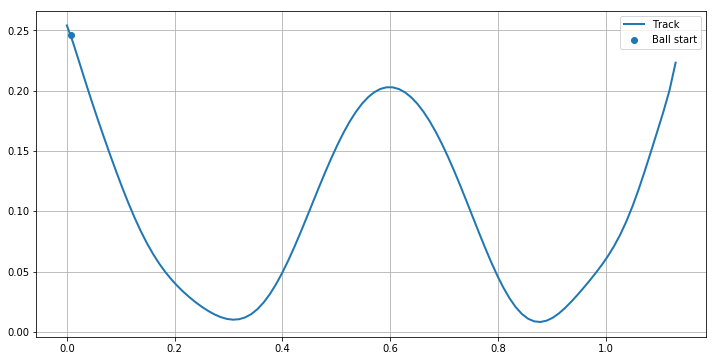

In [2]:
def trackLoading():
    (ball_x, ball_y), polynomial, track_end_x = tracker_1() #trackerData("test_data/mass_a.txt")
    steps = 100
    x = np.linspace(0, track_end_x, steps)
    y = np.polyval(polynomial, x)
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, linewidth=2, label="Track")
    plt.scatter(ball_x, ball_y, label="Ball start")
    plt.legend()
    plt.show()

trackLoading()

## Animating a position over a simple curve

Let's try animation with a very simple parabola, $x^2 - 1.5x + 0.57$

C:\Users\krire\OneDrive\Documents\MTDT\19V\Fysikk\Numerikk\numerics\matte4\ode.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  h = 0.8*(tol/error_estimate)**(1/(p+1))*h


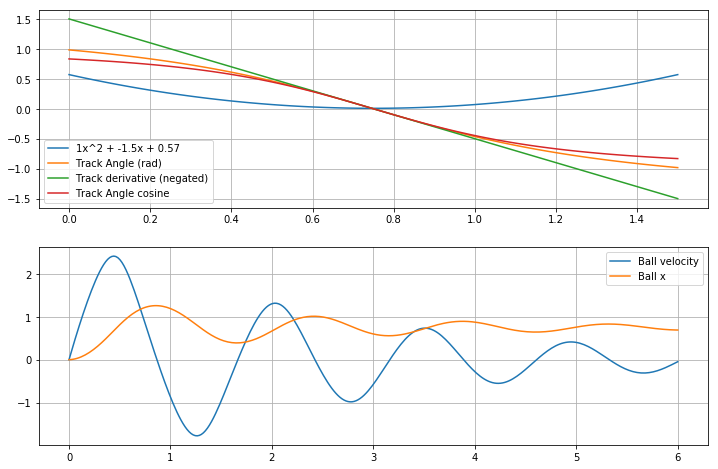

In [3]:
# Just showing the curve
def simpleCurve():
    parabola = [1, -1.5, 0.57]
    d_parabola = np.polyder(parabola)

    steps = 100
    framerate = 20/1000
    frame_count = 300
    

    x_pos = [0]
    vel = [0]
    for i in range(frame_count-1):
        time = i*framerate
        
        # Bruker matte4-funksjoner, heh
        # part 1
        # v'=sin(alpha)*9.81
        # where functions ode_adaptive ask for x, think t for time instead.
        current_x = x_pos[-1]
        def accell(t, v):
            track_angle = np.arctan(-np.polyval(d_parabola, current_x))
            return np.sin(track_angle)*9.81 - 0.8*vel[-1]
        
        t_num, v_num = ode_adaptive(accell, x0=0, xend=framerate, y0=vel[-1], h0=0.2)
        vel.append(v_num[-1])
        
        #part 2
        def velocity(t, x):
            return v_num[-1]
        
        t_num, x_num = ode_adaptive(velocity, x0=0, xend=framerate, y0=current_x, h0=0.2)
        x_pos.append(x_num[-1])
        # END matte 4
    
    x = np.linspace(0, 1.5, steps)
    y = np.polyval(parabola, x)
    
    time_axis = np.linspace(0, frame_count*framerate, frame_count)
    
    # Plot
    fig, (x_ax, t_ax) = plt.subplots(2, figsize=[12, 8])
    x_ax.plot(x, y, label=f"{parabola[0]}x^2 + {parabola[1]}x + {parabola[2]}")
    x_ax.plot(x, np.arctan(-np.polyval(d_parabola, x)), label="Track Angle (rad)")
    x_ax.plot(x, -np.polyval(d_parabola, x), label="Track derivative (negated)")
    x_ax.plot(x, np.sin(np.arctan(-np.polyval(d_parabola, x))), label="Track Angle cosine")
    x_ax.legend()
    
    t_ax.plot(time_axis, vel, label="Ball velocity")
    t_ax.plot(time_axis, x_pos, label="Ball x")
    t_ax.legend()
    
    #plt.show()

simpleCurve()

Total duration of animation is 5.6000000000000005s


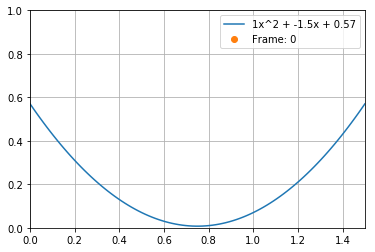

In [4]:
def curveAnimation():
    fig, ax = plt.subplots()

    plt.xlim((0, 1.5))
    # Background path using the curve
    parabola = [1, -1.5, 0.57]
    d_parabola = np.polyder(parabola)
    steps = 100
    x = np.linspace(0, 1.5, steps)
    y = np.polyval(parabola, x)
    plt.plot(x, y, label=f"{parabola[0]}x^2 + {parabola[1]}x + {parabola[2]}")
    plt.legend()
    
    # Animated line
    ax.set_xlim(( 0, 1.5))
    ax.set_ylim((0, 1))
    line, = ax.plot([], [], linestyle='None', marker="o", label="Frame: 0")
    ax.legend()
    
    # Animation settings
    framerate = 16/1000
    frame_count = 350
    print(f"Total duration of animation is {framerate*frame_count}s")

    def init():
        line.set_data([], [])
        return (line,)
        
    x_pos = [0]
    y_pos = [np.polyval(parabola, x_pos[0])]
    vel = [0]
        
    def animate(frame):
        # Bruker matte4-funksjoner, heh
        
        # part 1 - integrate acceleration to get velocity
        # v'=sin(alpha)*9.81
        # where functions ode_adaptive ask for x, think t for time instead.
        current_x = x_pos[-1]
        def accell(t, v):
            track_angle = np.arctan(-np.polyval(d_parabola, current_x))
            return np.sin(track_angle)*9.81 - 0.8*vel[-1]
        
        t_num, v_num = ode_adaptive(accell, x0=0, xend=framerate, y0=vel[-1], h0=framerate/2)
        # Save velocity
        vel.append(v_num[-1])
        
        #part 2 - integrate velocity to get position
        def velocity(t, x):
            return v_num[-1]
        
        t_num, x_num = ode_adaptive(velocity, x0=0, xend=framerate, y0=current_x, h0=framerate)
        
        # Save the values
        x_pos.append(x_num[-1])
        y_pos.append(np.polyval(parabola, x_num[-1]))
        
        # Update the animated point
        line.set_data(x_pos[-1], y_pos[-1])
        line.set_label(f"Frame {frame}, t={np.round(frame*framerate, 1)}. pos=({round(x_pos[-1],1)}, {round(y_pos[-1],1)}) ")
        ax.legend()
        return (line,) # Return all updated artists

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frame_count, interval=framerate*1000, 
                                   blit=True)
    rc('animation', html='jshtml')
    return anim

anim = curveAnimation()
save_vid = False
if save_vid:
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=1/framerate, metadata=dict(artist='Kristian'), bitrate=1800)
    anim.save('out/1-simple-curve-ball.mp4', writer=writer)
    print("Saved!")

if run_slow:
    anim

In [5]:
# Curve with obstacle animation
def obstacleCurveAnimation(parabola):
    fig, ax = plt.subplots()

    plt.xlim((TRACK_START_X, TRACK_END_X))
    # Background path using the curve
    d_parabola = np.polyder(parabola)
    steps = 100
    x = np.linspace(TRACK_START_X, TRACK_END_X, steps)
    y = np.polyval(parabola, x)
    label = " ".join([f"{round(c, 1)}x^{len(parabola)-i}" for i, c in enumerate(parabola)])
    plt.plot(x, y, label=label)
    plt.legend()
    
    # Animated line
    ax.set_xlim((TRACK_START_X, TRACK_END_X))
    ax.set_ylim((-0.2, 1))
    line, = ax.plot([], [], linestyle='None', marker="o", label="Frame: 0")
    ax.legend()
    
    # Animation settings
    framerate = 16/1000
    frame_count = 350
    print(f"Total duration of animation is {framerate*frame_count}s")

    def init():
        line.set_data([], [])
        return (line,)
        
    x_pos = [0]
    y_pos = [np.polyval(parabola, x_pos[0])]
    vel = [0]
        
    def animate(frame):
        # Bruker matte4-funksjoner, heh
        
        # part 1 - integrate acceleration to get velocity
        # v'=sin(alpha)*9.81
        # where functions ode_adaptive ask for x, think t for time instead.
        current_x = x_pos[-1]
        track_angle = np.arctan(-np.polyval(d_parabola, current_x))

        def accell(t, v):
            gravity = 9.81
            braking_factor = 0.4
            return (5/7)*gravity*np.sin(track_angle) - braking_factor*v
        
        t_num, v_num = ode_adaptive(accell, x0=0, xend=framerate, y0=vel[-1], h0=framerate/2)
        # Save velocity
        vel.append(v_num[-1])
        
        #part 2 - integrate velocity to get position
        def velocity(t, x):
            angle = np.arctan(-np.polyval(d_parabola, x))
            return v_num[-1]*np.cos(angle)
        
        t_num, x_num = ode_adaptive(velocity, x0=0, xend=framerate, y0=current_x, h0=framerate)
        
        # Save the values
        x_pos.append(x_num[-1])
        y_pos.append(np.polyval(parabola, x_num[-1]))
        
        # Update the animated point
        line.set_data(x_pos[-1], y_pos[-1])
        line.set_label(f"Frame {frame}, t={np.round(frame*framerate, 1)}. pos=({round(x_pos[-1],1)}, {round(y_pos[-1],1)}) ")
        ax.legend()
        return (line,) # Return all updated artists
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frame_count, interval=framerate*1000, 
                                   blit=True)
    rc('animation', html='jshtml')
    return anim

Wait a few seconds for the animation to show
Total duration of animation is 5.6000000000000005s


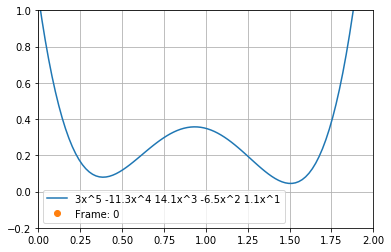

In [6]:
# Running the animation function
def showAnimation():
    parabola = [3, -11.3, 14.08, -6.508, 1.0768]
    anim = obstacleCurveAnimation(parabola)
    save_vid = False
    if save_vid:
        # Set up formatting for the movie files
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=1/framerate, metadata=dict(artist='Kristian'), bitrate=1800)
        anim.save('out/1-simple-curve-ball.mp4', writer=writer)
        print("Saved!")
    return anim

print("Wait a few seconds for the animation to show")
anim = showAnimation()
if run_slow:
    anim

# Justerbare polynomer

Vi trenger et uttrykk som kan gi polynomer ut i fra høyden på midten.

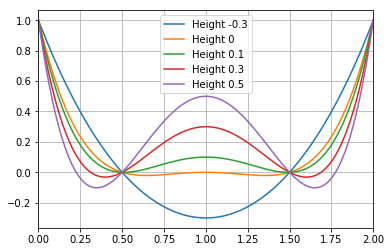

In [7]:
def makePolynom(height):
    points = [(0, 1), (0.5, 0), (1, height), (1.5, 0), (2, 1)]
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    return np.polyfit(x, y, len(points)-1)

def plotPolynomer():
    steps = 100
    x = np.linspace(TRACK_START_X, TRACK_END_X, steps)
    heights = [-0.3, 0, 0.1, 0.3, 0.5]
    polynoms = [makePolynom(h) for h in heights]
    
    plt.xlim((0, 2))
    for i, p in enumerate(polynoms):
        y = np.polyval(p, x)
        plt.plot(x, y, label=f"Height {heights[i]}")
    
    plt.legend()
    plt.show()

plotPolynomer()

# Animating with different parabola heights

In [8]:
print("Wait a few seconds for the animation to show")
if run_slow:
    obstacleCurveAnimation(makePolynom(0.2))

Wait a few seconds for the animation to show


# Detecting passing the obstacle

a passing of the obstacle could be detected by looking at $x(t_1), x(t_2), v(t_1)$ and verifying that $x$ moved past the point $x=x_{obstacle}$ (test with $ x_{obstacle} \in \left(x(t_1), x(t_2)\right) $) while $v$ was positive for $x(t_1) < x_{obstacle}$ and negative for $x(t_1) > x_{obstacle}$.

Pass 0:
0	0	0
1	0.0	0.13759913411744748
2	0.02	0.27409482278754893
3	0.04	0.409488744158406
4	0.06	0.5437823635438759
5	0.08	0.6769767985375327
6	0.1	0.8090726716070352
7	0.12	0.9400699432528925
8	0.14	1.0699677170776454
9	0.16	1.198764005772717
10	0.18	1.3264554434415954
11	0.2	1.4530369244126111
12	0.22	1.5785011408919722
13	0.24	1.7028379801179525
14	0.26	1.8260337237105608
15	0.28	1.9480699642966257
16	0.3	2.068922109965871
17	0.32	2.1885572747159174
18	0.34	2.3069312308727667
19	0.36	2.4239838866582684
20	0.38	2.539632366914284
21	0.4	2.653760046871797
22	0.42	2.7661984426342214
23	0.44	2.8766958184450266
24	0.46	2.9848595263851756
25	0.48	3.090042479681862
26	0.5	3.191100247971163
27	0.52	3.285819108078552
28	0.54	3.369441700749603
29	0.56	3.4309370914971105
30	0.58	3.4490826316744005
31	0.6	3.41296120308771
32	0.62	3.3414181866706016
33	0.64	3.253375415549101
34	0.66	3.1591601174709
35	0.68	3.0647172815918036
36	0.7000000000000001	2.9743179391885195
37	0.72	2.8917923081617354
38

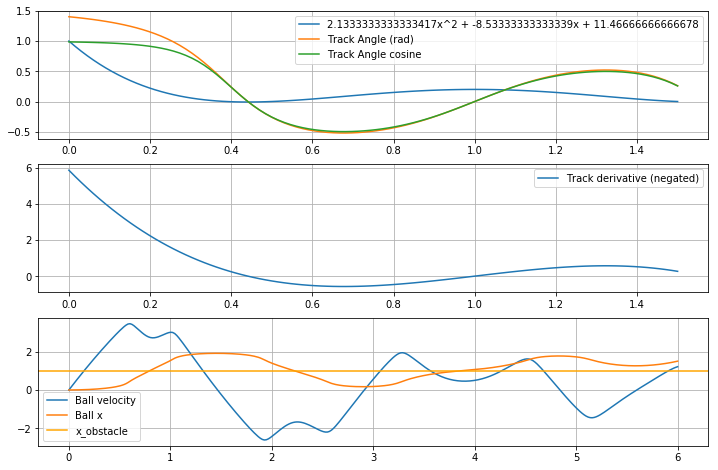

In [9]:
# Loop over and analyse x and v
def makePasses():
    parabola = makePolynom(0.2)
    d_parabola = np.polyder(parabola)

    steps = 100
    framerate = 20/1000
    frame_count = 300
    
    t = [0]
    x_pos = [0]
    vel = [0]
    for i in range(frame_count-1):
        time = i*framerate

        t.append(time)
        current_x = x_pos[-1]
        def accell(t, v):
            gravity = 9.81
            braking_factor = 0.4
            track_angle = np.arctan(-np.polyval(d_parabola, current_x))
            return (5/7)*gravity*np.sin(track_angle) - braking_factor*v
        
        t_num, v_num = ode_adaptive(accell, x0=0, xend=framerate, y0=vel[-1], h0=0.2)
        vel.append(v_num[-1])
        
        #part 2
        def velocity(t, x):
            angle = np.arctan(-np.polyval(d_parabola, x))
            return v_num[-1]*np.cos(angle)
        
        t_num, x_num = ode_adaptive(velocity, x0=0, xend=framerate, y0=current_x, h0=0.2)
        x_pos.append(x_num[-1])
        # END matte 4
    
    x = np.linspace(0, 1.5, steps)
    y = np.polyval(parabola, x)
    
    time_axis = np.linspace(0, frame_count*framerate, frame_count)
    
    # Plot
    fig, (x_ax, x_ax2, t_ax) = plt.subplots(3, figsize=[12, 8])
    x_ax.plot(x, y, label=f"{parabola[0]}x^2 + {parabola[1]}x + {parabola[2]}")
    x_ax.plot(x, np.arctan(-np.polyval(d_parabola, x)), label="Track Angle (rad)")
    x_ax.plot(x, np.sin(np.arctan(-np.polyval(d_parabola, x))), label="Track Angle cosine")
    x_ax.legend()
    
    x_ax2.plot(x, -np.polyval(d_parabola, x), label="Track derivative (negated)")
    x_ax2.legend()
    
    t_ax.plot(time_axis, vel, label="Ball velocity")
    t_ax.plot(time_axis, x_pos, label="Ball x")
    t_ax.axhline(1, label="x_obstacle", color="orange")
    t_ax.legend()
    
    return (t, x_pos, vel)

def contains(a, b, obstacle):
    return (a <= obstacle <= b) or (b <= obstacle <= a)

def detectPasses(times, x, velocities, obstacle_x):
    to_chunk = deque(enumerate(velocities)) # [(index, velocity)]
    chunks = [[]]
    current_sign = np.sign([vel[1] for vel in to_chunk if vel[1] != 0][0])
    while len(to_chunk) > 0:
        i, v = to_chunk.popleft()
        sign = np.sign(v)
        if sign != current_sign and sign != 0:
            current_sign = sign
            chunks.append([])
        chunks[-1].append((i, v, times[i]))
    #print(f"Got {len(chunks)} chunks where speed is the same direction")
    
    obstacle_passes = [chunk for chunk in chunks if len(chunk) > 2 and contains(x[chunk[0][0]], x[chunk[-1][0]], obstacle_x)]
    return obstacle_passes

(t, x, v) = makePasses()
obstacle_x = 1
passes = detectPasses(t, x, v, obstacle_x)
for i, chunk in enumerate(passes):
    print(f"Pass {i}:")
    for j, vel, time in chunk:
        print(f"{j}\t{time}\t{vel}")

# Using our integrator class

Calculating to time 9.6s


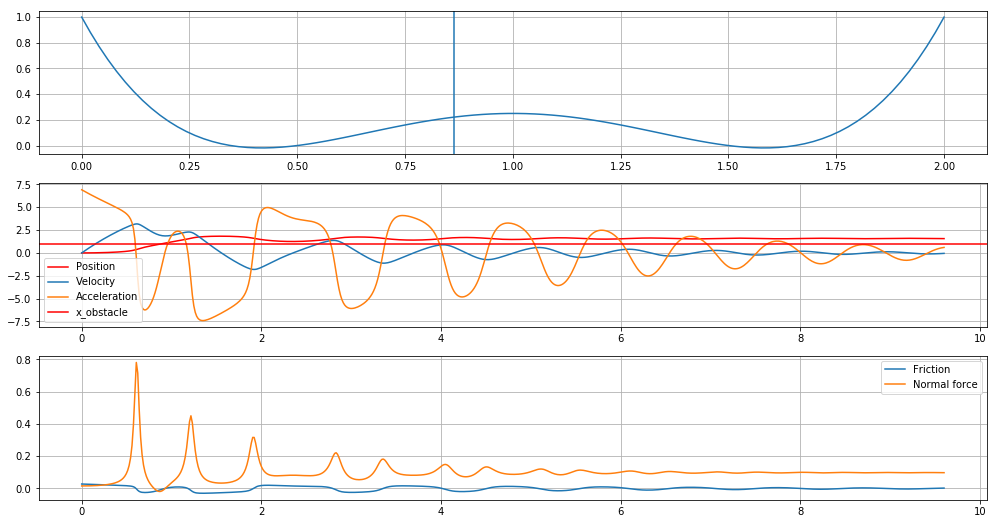

In [10]:
def useClass():
    ball = num_integ.Ball(mass=0.01, radius=0.01, start_x=0, start_y=0.7)
    polynom = makePolynom(0.25)
    track = num_integ.Track(polynom, start_height=1, obstacle_height=0.25, end_height=1)
    
    integrator = num_integ.BallIntegrator(ball, track)
    integrator.timestep = 0.016
    integrator.braking_factor=0.8
    
    steps = 600
    print(f"Calculating to time {steps*integrator.timestep}s")
    for step in range(steps):
        integrator.step()
    
    forceCalculator = num_integ.ForceCalculator(track, ball, integrator.time, integrator.position, integrator.velocity, integrator.acceleration)
    passChecker = num_integ.ObstaclePassChecker(obstacle_x=1) # x defined in makePolynom
    frictions, normalForces = forceCalculator.calculate()
    
    flight = None
    for i, n in enumerate(normalForces):
        if n < 0:
            flight = integrator.position[i]
            break
    
    # Plot stuff
    fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(17, 9))
    x = np.linspace(0, 2, 100)
    ax0.plot(x, np.polyval(polynom, x))
    if flight:
        ax0.axvline(x=flight)
    
    ax1.plot(integrator.time, integrator.position, label="Position", color="red")
    ax1.plot(integrator.time, integrator.velocity, label="Velocity")
    ax1.plot(integrator.time, integrator.acceleration, label="Acceleration")
    ax1.axhline(1, label="x_obstacle", color="red")
    ax1.legend()
    
    ax2.plot(integrator.time, frictions, label="Friction")
    ax2.plot(integrator.time, normalForces, label="Normal force")
    ax2.legend()


useClass()

# Testing multiple parabolas for 2 passes

Pass 0:
0	0	0
1	0.0	0.13759913411744748
2	0.02	0.27409482278754893
3	0.04	0.409488744158406
4	0.06	0.5437823635438759
5	0.08	0.6769767985375327
6	0.1	0.8090726716070352
7	0.12	0.9400699432528925
8	0.14	1.0699677170776454
9	0.16	1.198764005772717
10	0.18	1.3264554434415954
11	0.2	1.4530369244126111
12	0.22	1.5785011408919722
13	0.24	1.7028379801179525
14	0.26	1.8260337237105608
15	0.28	1.9480699642966257
16	0.3	2.068922109965871
17	0.32	2.1885572747159174
18	0.34	2.3069312308727667
19	0.36	2.4239838866582684
20	0.38	2.539632366914284
21	0.4	2.653760046871797
22	0.42	2.7661984426342214
23	0.44	2.8766958184450266
24	0.46	2.9848595263851756
25	0.48	3.090042479681862
26	0.5	3.191100247971163
27	0.52	3.285819108078552
28	0.54	3.369441700749603
29	0.56	3.4309370914971105
30	0.58	3.4490826316744005
31	0.6	3.41296120308771
32	0.62	3.3414181866706016
33	0.64	3.253375415549101
34	0.66	3.1591601174709
35	0.68	3.0647172815918036
36	0.7000000000000001	2.9743179391885195
37	0.72	2.8917923081617354
38

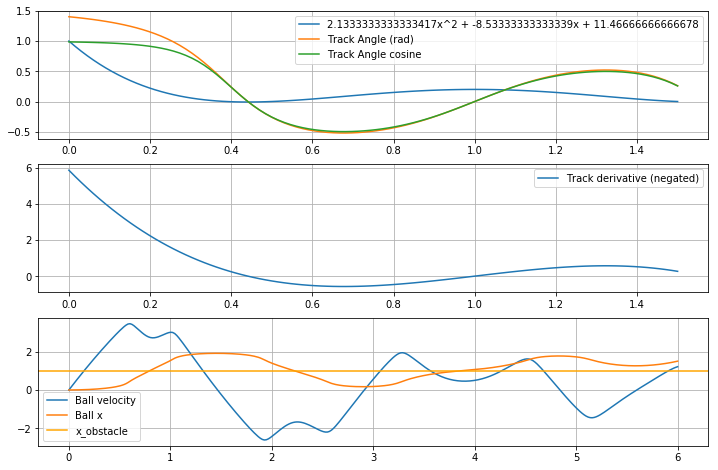

In [11]:
# TODO
(t, x, v) = makePasses()
obstacle_x = 1
passes = detectPasses(t, x, v, obstacle_x)
for i, chunk in enumerate(passes):
    print(f"Pass {i}:")
    for j, vel, time in chunk:
        print(f"{j}\t{time}\t{vel}")

# Running with real data

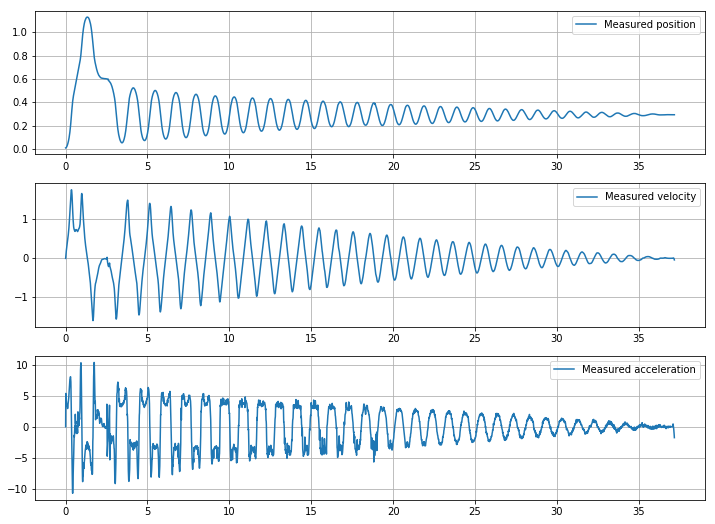

Found 2 passes


In [12]:
def count_passes_track1():
    data = load_p1100902()
    data = filter_values.calculate_track_values(data)
    t = data[:,0]
    x = data[:,1]
    velocities = data[:,3]
    accelerations = data[:,4]
    
    fig, (plt1, plt2, plt3) = plt.subplots(3, 1, figsize=(12,9))
    #plt1.set_xlim(0, 2.7)
    #plt2.set_xlim(0, 2.7)
    #plt3.set_xlim(0, 2.7)
    
    plt1.plot(t, x, label="Measured position")
    plt2.plot(t, velocities, label="Measured velocity")
    plt3.plot(t, accelerations, label="Measured acceleration")
    plt1.legend()
    plt2.legend()
    plt3.legend()
    plt.show()
    
    obstacle_x = 0.59890243
    passes = detectPasses(t, x, velocities, obstacle_x)
    print(f"Found {len(passes)} passes")
    #for i, chunk in enumerate(passes):
    #    print(f"Pass {i}:")
    #    for j, vel, time in chunk:
    #        print(f"{j}\t{time}\t{vel}")

count_passes_track1()

0.007789790225 0.2459166329 1.130102522
Obstacle at 0.59890243
Calculating to time 20.0s
Found 2 passes


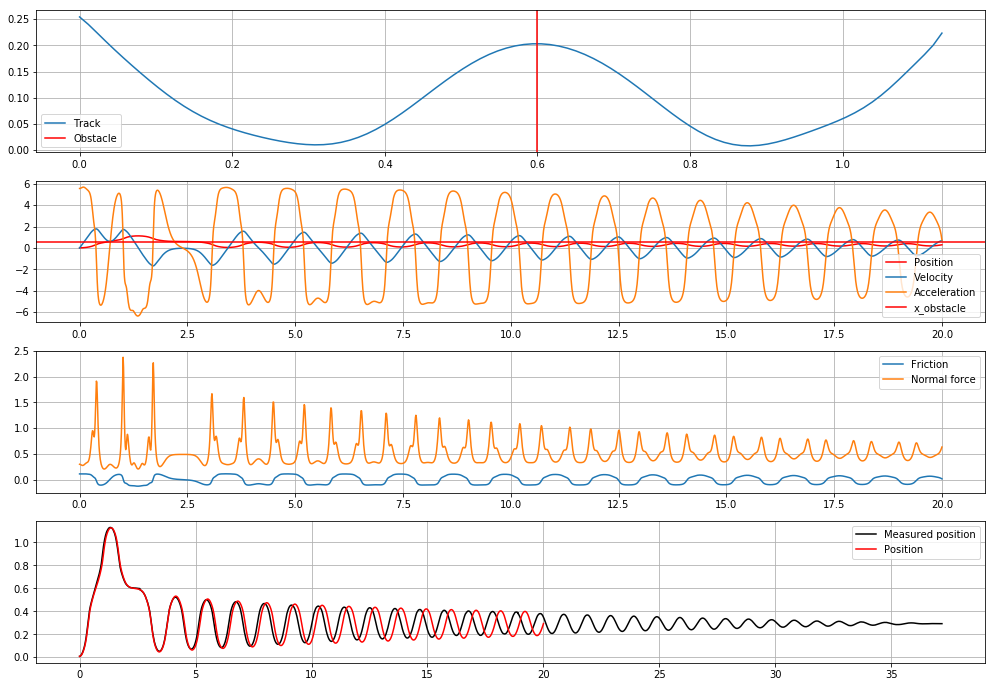

In [13]:

def useReal():
    measured_data = load_p1100902() # For comparison

    (ball_x, ball_y), polynom, track_end_x = tracker_1()
    obstacle_x = 0.59890243
    #print(f"Roots at {np.roots(np.polyder(polynom))}")
    print(f"Obstacle at {obstacle_x}")
    
    ball = num_integ.Ball(mass=0.05, radius=0.0189/2, start_x=ball_x, start_y=ball_y)
    track = num_integ.Track(polynom, start_height=0.3, obstacle_height=0.238, end_height=0.3)
    
    integrator = num_integ.BallIntegrator(ball, track, braking_factor=0.11097230149082478) # Found later
    integrator.timestep = 0.01
    
    steps = 2000
    print(f"Calculating to time {steps*integrator.timestep}s")
    for step in range(steps):
        integrator.step()
    
    forceCalculator = num_integ.ForceCalculator(track, ball, integrator.time, integrator.position, integrator.velocity, integrator.acceleration)
    passChecker = num_integ.ObstaclePassChecker(obstacle_x=1) # x defined in makePolynom
    frictions, normalForces = forceCalculator.calculate()
    
    flight = None
    for i, n in enumerate(normalForces):
        if n < 0:
            flight = integrator.position[i]
            break
    
    passes = detectPasses(integrator.time, integrator.position, integrator.velocity, obstacle_x)
    print(f"Found {len(passes)} passes")
    
    # Plot stuff
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(17, 12))
    x = np.linspace(0, track_end_x, 100)
    ax0.plot(x, np.polyval(polynom, x), label="Track")
    ax0.axvline(obstacle_x, label="Obstacle", color="red")
    ax0.legend()
    if flight:
        ax0.axvline(x=flight, label="Error! Liftoff/flight here")
    
    ax1.plot(integrator.time, integrator.position, label="Position", color="red")
    ax1.plot(integrator.time, integrator.velocity, label="Velocity")
    ax1.plot(integrator.time, integrator.acceleration, label="Acceleration")
    ax1.axhline(obstacle_x, label="x_obstacle", color="red")
    ax1.legend()
    
    ax2.plot(integrator.time, frictions, label="Friction")
    ax2.plot(integrator.time, normalForces, label="Normal force")
    ax2.legend()
    
    ax3.plot(measured_data[:,0], measured_data[:,1], label="Measured position", color="black")
    ax3.plot(integrator.time, integrator.position, label="Position", color="red")
    ax3.legend()

useReal()


# Trying to find the closest match for braking factor

Run 0. Factor 0.13--------------------
Invalid braking factor 0.13, 1 passes
Found 1 passes with factor 0.13. Range (0.095, 0.4)
Adjusted factors: 0.1125 in range (0.095, 0.13)
Run 1. Factor 0.1125--------------------
Invalid braking factor 0.1125, 1 passes
Found 1 passes with factor 0.1125. Range (0.095, 0.13)
Adjusted factors: 0.10375000000000001 in range (0.095, 0.1125)
Run 2. Factor 0.10375000000000001--------------------
Found better factor: 0.10375000000000001 with error 0.002106042948863202
Run 3. Factor 0.09481399870265449--------------------
Run 4. Factor 0.09928199935132725--------------------
Run 5. Factor 0.09901133411519464--------------------
Run 6. Factor 0.10138066705759732--------------------
Run 7. Factor 0.10527302319576103--------------------
Found better factor: 0.10527302319576103 with error 0.001732799222794128
Run 8. Factor 0.1040210611922421--------------------
Run 9. Factor 0.10464704219400156--------------------
Run 10. Factor 0.114464450407169---------------

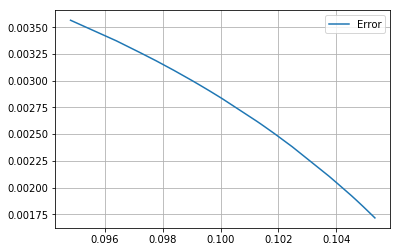

----------------------------------------------------------------------------------------------------
Best value found: 0.10533493194411805 (error=0.0017163380758901461)


In [14]:
def calculate_measured_values(obstacle_x = 0.59890243):
    data = load_p1100902()
    velocities = [0]
    for i, (t, x, y) in enumerate(data[1:]):
        (prev_x, prev_y) = data[i-1][1:]
        distance = (x-prev_x)
        delta_time = t - data[i-1][0]
        velocities.append(distance/delta_time)
    
    t = data[:,0]
    x = data[:,1]
    
    passes = detectPasses(t, x, velocities, obstacle_x)

    return t, x, velocities

def simulate_with_braking(braking_factor=0.1119893, obstacle_x = 0.59890243, steps = 600, timestep=0.016):
    """
    :return: False|int|tuple, int if passes are invalid
    """
    (ball_x, ball_y), polynom, track_end_x = tracker_1()
    
    ball = num_integ.Ball(mass=0.05, radius=0.0189/2, start_x=ball_x, start_y=ball_y)
    track = num_integ.Track(polynom, start_height=0.3, obstacle_height=0.238, end_height=0.3)
    
    integrator = num_integ.BallIntegrator(ball, track, braking_factor=braking_factor)
    integrator.timestep = timestep
    
    for step in range(steps):
        integrator.step()
    
    forceCalculator = num_integ.ForceCalculator(track, ball, integrator.time, integrator.position, integrator.velocity, integrator.acceleration)
    passChecker = num_integ.ObstaclePassChecker(obstacle_x)
    passes = detectPasses(integrator.time, integrator.position, integrator.velocity, obstacle_x)

    if len(passes) != 2:
        print(f"Invalid braking factor {braking_factor}, {len(passes)} passes")
        return len(passes)
    
    frictions, normalForces = forceCalculator.calculate()    
    for i, n in enumerate(normalForces):
        if n < 0:
            print(f"Invalid setup. Ball flies at force index {i}")
            return False
    
    return (integrator.time, integrator.position, integrator.velocity)

def find_error(measured_t, measured_x, calc_t, calc_x):
    """
    :return: float, the error
    """
    # 1: interpolate to match t values
    # 2: diff x values at interpolated values
    if len(measured_x) != len(calc_x):
        raise Exception(f"Must be same size! {len(measured_x)} vs {len(calc_x)}")
    return np.square(np.sum(np.square(calc_x - measured_x))/len(measured_x))
    

def find_close_match():
    (meas_t, meas_x, meas_v) = calculate_measured_values()
    braking_factor = 0.13 #0.111
    low_factor = 0.095
    high_factor = 0.4
    
    last_error = np.inf
    smallest_error = np.inf
    best_factor = braking_factor
    
    compare_size = 600
    frame_rate_seconds=0.01
    
    errors = []
    
    for run_number in range(30):
        print(f"Run {run_number}. Factor {braking_factor}" + "-"*20)
        simulated = simulate_with_braking(braking_factor=braking_factor, steps=compare_size-1, timestep=frame_rate_seconds)
        if isinstance(simulated, bool) and simulated == False:
            # Flight
            low_factor = braking_factor
            braking_factor = (high_factor + low_factor) / 2
        elif isinstance(simulated, int):
            # Invalid pass number
            passes = simulated
            print(f"Found {passes} passes with factor {braking_factor}. Range ({low_factor}, {high_factor})")
            if passes < 2:
                high_factor = braking_factor
            elif passes > 2:
                low_factor = braking_factor
            braking_factor = (high_factor + low_factor)/2
            print(f"Adjusted factors: {braking_factor} in range ({low_factor}, {high_factor})")
        else:
            # Normal case
            (calc_t, calc_x, calc_v) = simulated
            error = find_error(meas_t[:compare_size], meas_x[:compare_size], calc_t, calc_x)
            errors.append((braking_factor, error))
            
            if error < smallest_error:
                # New best case
                smallest_error = error
                best_factor = braking_factor
                print(f"Found better factor: {braking_factor} with error {error}")
            
            # Assuming error is in a valley, from previous graphed runs
            if error > last_error:
                # Error too far from best case, go back towards best
                braking_factor = (best_factor + braking_factor) / 2
            else:
                # Look around best case
                braking_factor = random.uniform(0.9, 1.1)*best_factor
            last_error = error
    
    errors = np.array(sorted(errors, key=lambda err: err[0]))
    plt.plot(errors[:,0], errors[:,1], label="Error")
    plt.legend()
    plt.show()
    
    print("-"*100)
    print(f"Best value found: {best_factor} (error={smallest_error})")
    # 0.11097230149082478 (error=4.3536731384222186e-07)
    # 0.11098230149082479 (error=3.340337453326927e-06) with 800 compare_size

find_close_match()